
# Additional Spatial Analysis Methods: Point Patterns



In [6]:
!pip install pysal

Processing /home/jovyan/.cache/pip/wheels/14/c7/6d/ff221048ff1200560c8877c6098c8f54df5fa14de01119a152/pysal-2.3.0-py3-none-any.whl
  Using cached coverage-5.3-cp38-cp38-manylinux1_x86_64.whl (230 kB)
  Using cached pytest_cov-2.10.1-py2.py3-none-any.whl (19 kB)
  Using cached pytest-6.1.2-py3-none-any.whl (272 kB)
Processing /home/jovyan/.cache/pip/wheels/04/56/0d/aaa8d7c0dedde9ad7cdb5882229ed287aacd78b1e648b5b7a1/spglm-1.0.8-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/32/5b/47/f5255524be1899a80f2c0f492a4df4dea4e84f82371e69dce8/inequality-1.0.0-py3-none-any.whl
  Using cached spaghetti-1.5.3-py3-none-any.whl (43 kB)
  Using cached segregation-1.4.0-py3-none-any.whl (83 kB)
  Using cached python_dateutil-2.8.0-py2.py3-none-any.whl (226 kB)
  Using cached urllib3-1.24.3-py2.py3-none-any.whl (118 kB)
  Using cached access-1.1.1-py3-none-any.whl (21 kB)
  Using cached tobler-0.4.0-py3-none-any.whl (19 kB)
Processing /home/jovyan/.cache/pip/wheels/7b/03/6b/b0a4a4e878a7e057ba4

  Using cached simplejson-3.17.2-cp38-cp38-manylinux2010_x86_64.whl (137 kB)
ERROR: pyppeteer 0.2.2 has requirement urllib3<2.0.0,>=1.25.8, but you'll have urllib3 1.24.3 which is incompatible.
ERROR: osmnx 0.16.0 has requirement matplotlib>=3.3, but you'll have matplotlib 3.2.2 which is incompatible.
ERROR: osmnx 0.16.0 has requirement networkx>=2.5, but you'll have networkx 2.4 which is incompatible.
ERROR: osmnx 0.16.0 has requirement pandas>=1.1, but you'll have pandas 1.0.5 which is incompatible.
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.9
    Uninstalling urllib3-1.25.9:
      Successfully uninstalled urllib3-1.25.9


In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
# for basemaps
import contextily as ctx

# to import data from LA Data portal
from sodapy import Socrata

import seaborn as sns

import plotly.express as px

from pointpats import centrography

In [8]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2020-03-01T00:00:00' and '2020-10-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)


In [9]:
# convert pandas dataframe to geodataframe
arrests = gpd.GeoDataFrame(arrests, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [10]:
# convert lat/lon to floats
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

In [11]:
# drop the unmapped rows
arrests.drop(arrests[arrests.lon==0].index,inplace=True)

In [17]:
# project to web mercator
arrests=arrests.to_crs('EPSG:3857')

## Plots

In [39]:
sns.__version__

'0.10.1'

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'hue'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


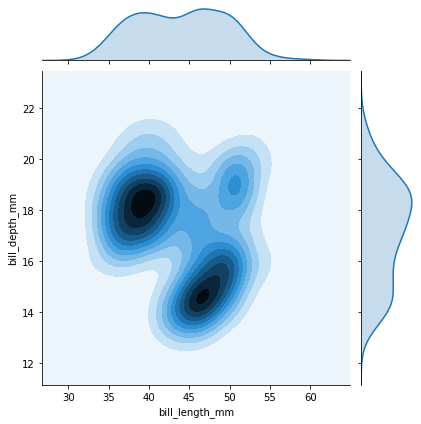

In [36]:
# sns.set_theme(style="ticks")

# Load the penguins dataset
penguins = sns.load_dataset("penguins")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=penguins,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    kind="kde",
)

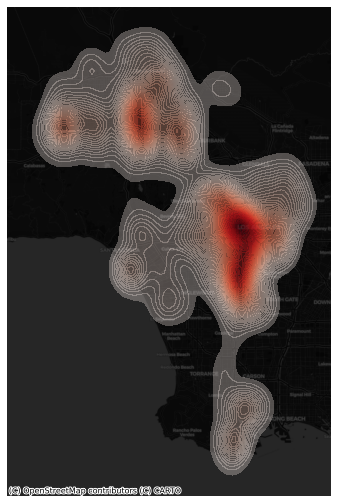

In [33]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(arrests[arrests.descent_cd=='H'].geometry.x, 
                arrests[arrests.descent_cd=='H'].geometry.y,
                n_levels=100, 
                shade=True,
                shade_lowest=False,
                alpha=0.3, 
                cmap='Reds')

# Remove axes
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)

## Mapbox heatmap

In [ ]:

arrests = arrests.to_crs('EPSG:4326')
# what's the centroid?
minx, miny, maxx, maxy = arrests.geometry.total_bounds
center_lat = (maxy-miny)/2+miny
center_lon = (maxx-minx)/2+minx

In [ ]:
fig = px.density_mapbox(arrests, lat='lat', lon='lon',  radius=5,
                        center=dict(lat=center_lat, lon=center_lon), zoom=10,
                        mapbox_style="stamen-terrain")
fig.show()

## Centrography

In [19]:
arrests['x'] = arrests.geometry.x
arrests['y'] = arrests.geometry.y

In [20]:
mean_center = centrography.mean_center(arrests[['x','y']])
med_center = centrography.euclidean_median(arrests[['x','y']])

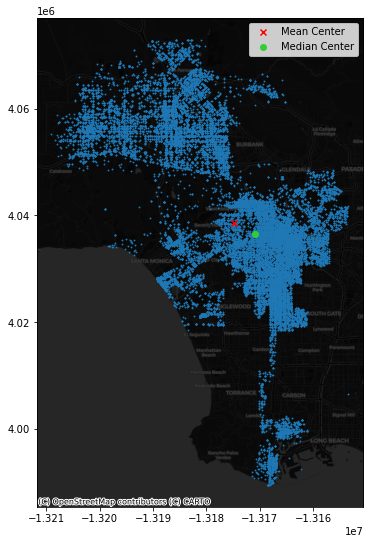

In [21]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context

# Plot photograph points
ax.scatter(arrests['x'], arrests['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

ax.legend()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
# Display
plt.show()

In [22]:
centrography.std_distance(arrests[['x','y']])

18948.762986814436

In [23]:
major, minor, rotation = centrography.ellipse(arrests[['x','y']])

In [24]:
from matplotlib.patches import Ellipse
import numpy

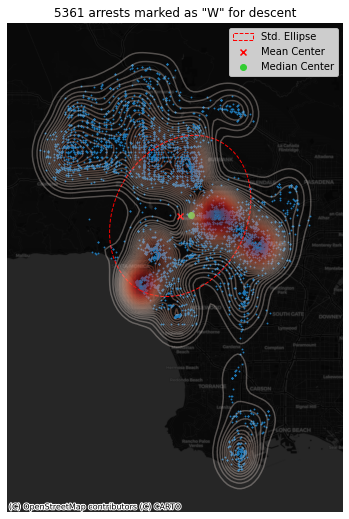

In [29]:
# filter the data by race
race = 'W'
arrests_filtered = arrests[arrests.descent_cd == race]

# mean center and median
mean_center = centrography.mean_center(arrests_filtered[['x','y']])
med_center = centrography.euclidean_median(arrests_filtered[['x','y']])

# standard ellipse
major, minor, rotation = centrography.ellipse(arrests_filtered[['x','y']])

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot arrest points
ax.scatter(arrests_filtered['x'], arrests_filtered['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# heatmap
seaborn.kdeplot(arrests_filtered.geometry.x, arrests_filtered.geometry.y,
                n_levels=50, shade=False,shade_lowest=False,
                alpha=0.3, cmap='Reds', ax=ax)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse db_filtered
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', linestyle='--',
                  label='Std. Ellipse')
ax.add_patch(ellipse)

ax.legend()

ax.axis('Off')

ax.set_title(str(len(arrests_filtered)) + ' arrests marked as "' + race + '" for descent')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
# Display
plt.show()

In [30]:
def arrest_ellipse_race(race='B'):
    # filter the data by race
    arrests_filtered = arrests[arrests.descent_cd == race]

    # mean center and median
    mean_center = centrography.mean_center(arrests_filtered[['x','y']])
    med_center = centrography.euclidean_median(arrests_filtered[['x','y']])

    # standard ellipse
    major, minor, rotation = centrography.ellipse(arrests_filtered[['x','y']])

    # Set up figure and axis
    fig, ax = plt.subplots(1, figsize=(9, 9))

    # Plot arrest points
    ax.scatter(arrests_filtered['x'], arrests_filtered['y'], s=1)
    ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
    ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

    # heatmap
    seaborn.kdeplot(arrests_filtered.geometry.x, arrests_filtered.geometry.y,
                    n_levels=50, shade=False,shade_lowest=False,
                    alpha=0.3, cmap='Reds', ax=ax)

    # Construct the standard ellipse using matplotlib
    ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                      width=major*2, # centrography.ellipse db_filtered
                      height=minor*2, 
                      angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                      facecolor='none', 
                      edgecolor='red', linestyle='--',
                      label='Std. Ellipse')
    ax.add_patch(ellipse)

    ax.legend()

    ax.axis('Off')

    ax.set_title(str(len(arrests_filtered)) + ' arrests marked as "' + race + '" for descent')
    
    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.DarkMatter)
    # Display
#     plt.show()
    
#     return fig

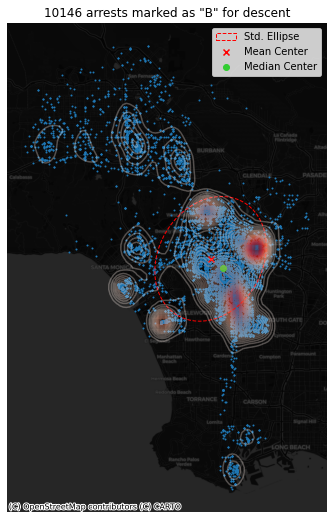

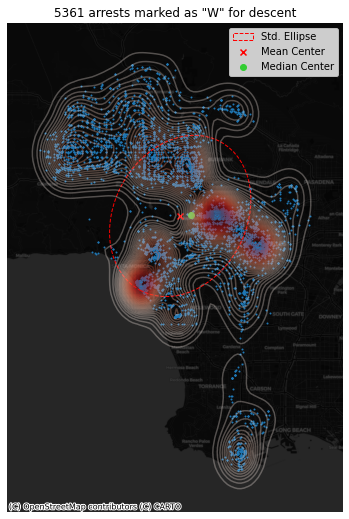

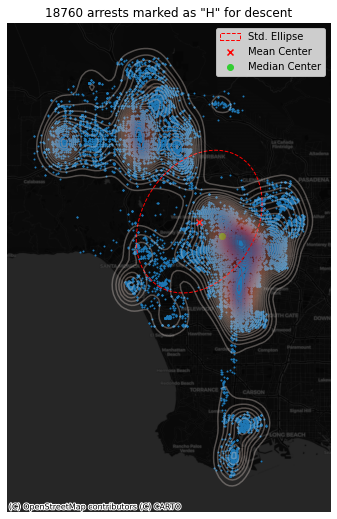

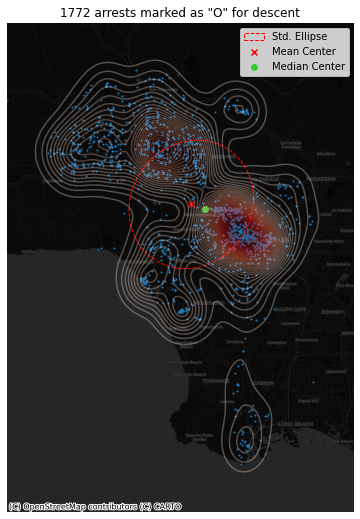

In [31]:
race_list = ['B','W','H','O']
for race in race_list:
    arrest_ellipse_race(race)